In [0]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [0]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz 

connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2020-03-21 11:26:34--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  10.4MB/s    in 7m 35s  

2020-03-21 11:34:10 (10.5 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [0]:
!mkdir data

In [0]:
!tar xzf food-101.tar.gz -C data/

In [0]:
path = Path("data/food-101/images/");
path.ls()

[PosixPath('data/food-101/images/sushi'),
 PosixPath('data/food-101/images/risotto'),
 PosixPath('data/food-101/images/spaghetti_carbonara'),
 PosixPath('data/food-101/images/grilled_cheese_sandwich'),
 PosixPath('data/food-101/images/fried_calamari'),
 PosixPath('data/food-101/images/apple_pie'),
 PosixPath('data/food-101/images/onion_rings'),
 PosixPath('data/food-101/images/cheese_plate'),
 PosixPath('data/food-101/images/grilled_salmon'),
 PosixPath('data/food-101/images/gnocchi'),
 PosixPath('data/food-101/images/crab_cakes'),
 PosixPath('data/food-101/images/churros'),
 PosixPath('data/food-101/images/garlic_bread'),
 PosixPath('data/food-101/images/hot_dog'),
 PosixPath('data/food-101/images/edamame'),
 PosixPath('data/food-101/images/carrot_cake'),
 PosixPath('data/food-101/images/lobster_roll_sandwich'),
 PosixPath('data/food-101/images/omelette'),
 PosixPath('data/food-101/images/steak'),
 PosixPath('data/food-101/images/french_toast'),
 PosixPath('data/food-101/images/frozen

In [0]:
src = (ImageList.from_folder(path)
      .split_by_rand_pct(0.3)
      .label_from_folder())

In [0]:
data = (src.transform(get_transforms(),size=224)
       .databunch(bs=64)
       .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (70700 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sushi,sushi,sushi,sushi,sushi
Path: data/food-101/images;

Valid: LabelList (30300 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pork_chop,cheesecake,hot_and_sour_soup,pad_thai,croque_madame
Path: data/food-101/images;

Test: None

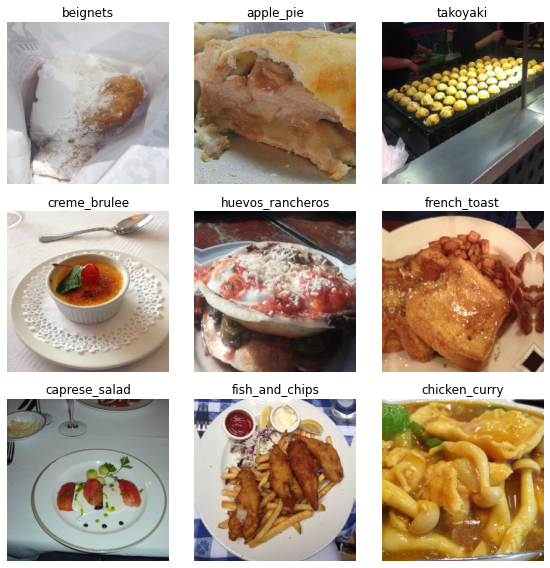

In [0]:
data.show_batch(3,figsize=(8,8))

# Modeling

In [0]:
learn = cnn_learner(data,models.resnet34,metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


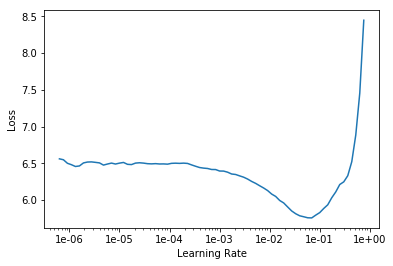

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.328996,2.116490,0.536601,0.463399,29:39
1,2.032616,1.850954,0.479175,0.520825,29:29
2,1.712325,1.539736,0.400990,0.599010,28:56
3,1.468245,1.225794,0.322310,0.677690,28:54
4,1.357460,1.161082,0.307690,0.692310,28:55


In [0]:
learn.save("res34-stg2")

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


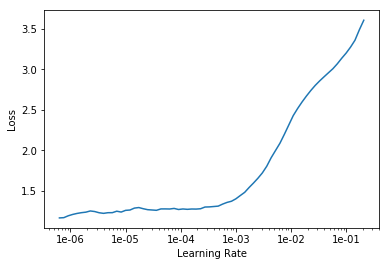

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,slice(7e-6,3e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.322185,1.130311,0.300165,0.699835,29:46
1,1.277643,1.078271,0.285908,0.714092,29:27
2,1.162712,1.027814,0.273069,0.726931,29:21
3,1.090793,1.004391,0.268416,0.731584,29:41
4,1.058855,1.002176,0.267921,0.732079,29:05


# Preparation to production

In [0]:
import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json


def predict(url):
    img = fetch_image(url)
    pred_class,pred_idx,outputs = learn.predict(img)
    res =  zip (learn.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:5]
    pprint.pprint( top_predictions)
    return img.resize(500)

In [0]:
def fetch_image(url):
    response = requests.get(url)
    img = open_image(BytesIO(response.content))
    return img

In [0]:
baby_back_url ="https://upload.wikimedia.org/wikipedia/commons/e/ee/Baby_back_ribs_with_fries.jpg"

[('baby_back_ribs', 0.960923433303833),
 ('steak', 0.024926189333200455),
 ('prime_rib', 0.006041612010449171),
 ('filet_mignon', 0.0041290647350251675),
 ('pulled_pork_sandwich', 0.0009785433067008853)]


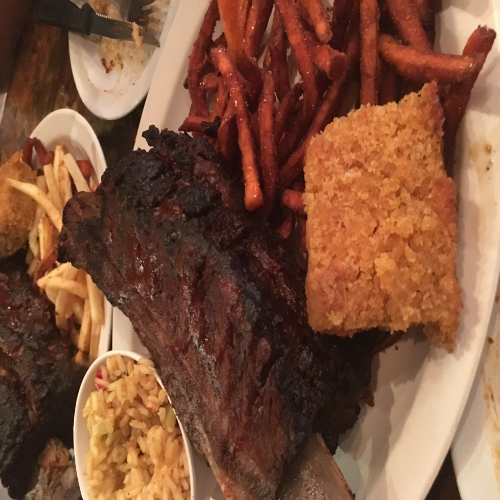

In [0]:
predict(baby_back_url)

In [0]:
learn.export()

In [0]:
data.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster